In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from preg_aging.cached_reader import get_tests
import os
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.size"] = 14
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 12

In [15]:
tests = get_tests(remove_urine=True, remove_percent=True, remove_pct=True)
print(len(tests))

62


In [5]:
from preg_aging.clalit_parser import group_tests

test_groups = group_tests(tests)

### eGFR difference

In [ ]:
from preg_aging.analyses import scr_to_egfr
from preg_aging.clalit_parser import get_clalit_data
scr_data = get_clalit_data("CREATININE_BLOOD").loc[-40:-1]
scr_max = scr_data["qval_mean"].argmax()
scr_max = scr_data["qval_mean"].argmin()



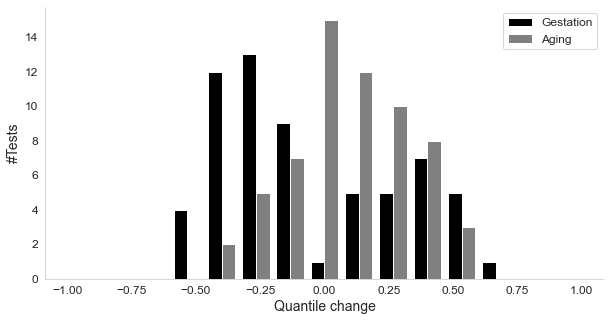

In [29]:
from preg_aging.plotting import plot_diffs_histogram
fig, axes = plot_diffs_histogram(tests, bins=10)
#fig.set_size_inches(7, 5)

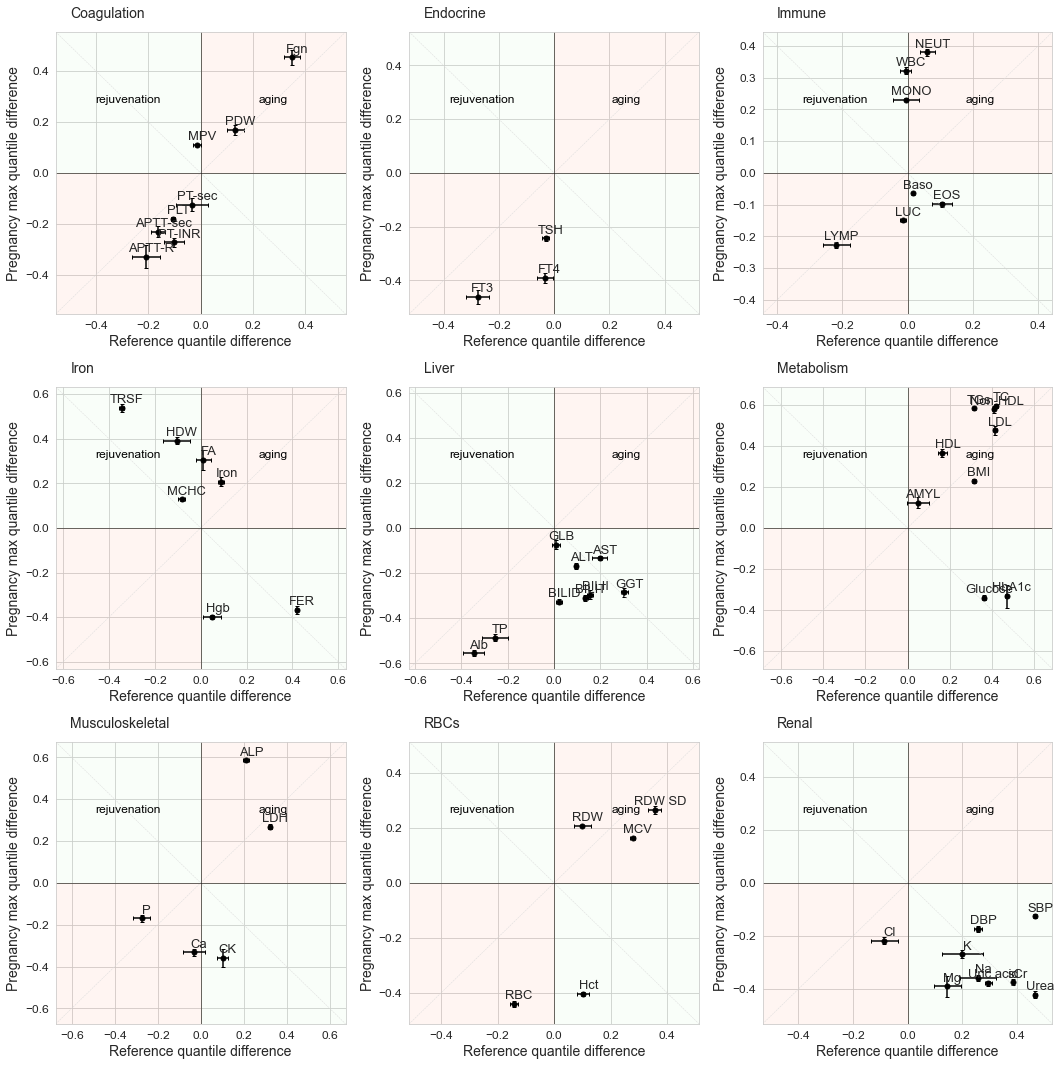

In [10]:
from preg_aging.plotting import plot_diff_grid
font_size = plt.rcParams.get('font.size')
plt.rcParams.update({'font.size': 14})
age_ref = [20, 80]
fig_preg, axs_preg = plot_diff_grid(test_groups, labnorm_age_ref=age_ref, test_period=[-40, -2])
# fig_pp, _ = plot_diff_grid(test_groups, test_period=[0, 80])
fig_preg.tight_layout()
fig_preg.savefig(os.path.join("graphs", f"quantile diff, preg_labnorm{str(age_ref)}.png"), dpi=150)
# fig_pp.tight_layout()
# fig_pp.savefig(os.path.join("graphs", "quantile diff, pp_labnorm.pdf"))
plt.show()
plt.rcParams.update({'font.size': font_size})

## Regression training and QA

In [24]:
from preg_aging.cached_reader import get_tests
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from src.preg_aging.sample_dataset import resample_per_age, normalize_by_sub_div
import pandas as pd
tests = get_tests(remove_urine=True, remove_percent=True, remove_pct=True)
complication_tests = get_tests(True, True, True, os.path.join("csvs", "tests_complications.json"))
regression, age = resample_per_age(tests, num_samples_per_age=200)#, range_to_fac={(20,36): 4, (36,71): 1, (71, 100): 3})
normalized_reg = normalize_by_sub_div(regression)
model = OLS(age, add_constant(regression)).fit()
norm_model = OLS(age, add_constant(normalized_reg)).fit()
comp_reg, comp_age = resample_per_age(complication_tests, num_samples_per_age=200)#, range_to_fac={(20,36): 4, (36,71): 1, (71, 100): 3})
comp_model = OLS(comp_age, add_constant(comp_reg)).fit()

In [25]:
from scipy.stats import pearsonr
regression_test, age_test = resample_per_age(tests, num_samples_per_age=200)
pearsonr(model.predict(add_constant(regression_test)), age_test)

PearsonRResult(statistic=np.float64(0.868037026557853), pvalue=np.float64(0.0))

<Axes: >

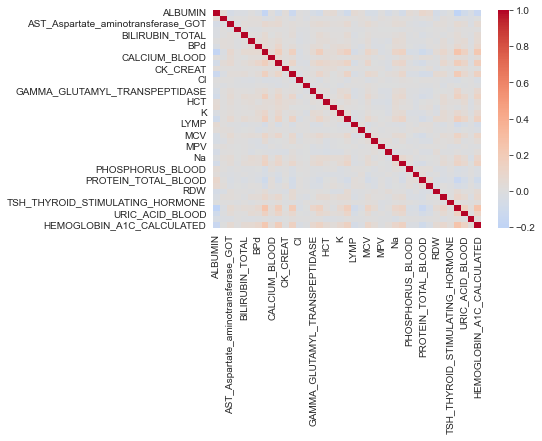

In [6]:
import seaborn as sns
from preg_aging.sample_dataset import normalize_by_sub_div
corr = comp_reg.corr()

sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)

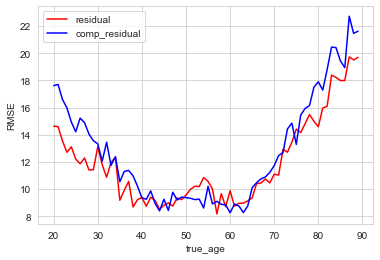

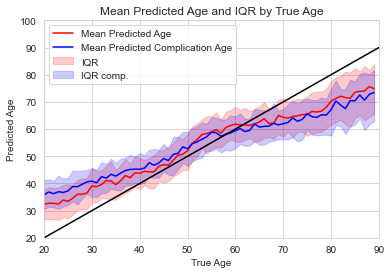

In [37]:
import matplotlib.pyplot as plt
predictions = model.predict(add_constant(regression))
resid = (predictions - age)
predictions_comp = comp_model.predict(add_constant(comp_reg))
comp_resid = (predictions_comp - comp_age)
pred_label_df = pd.DataFrame({"predicted_age": predictions, "true_age": age, "residual": resid ** 2, "predicted_comp_age": predictions_comp, "comp_residual": comp_resid ** 2})
predicted_age_group = pred_label_df.groupby("true_age")[["predicted_age", "predicted_comp_age"]]
mean_predicted_age = predicted_age_group.mean()
mse_plot = (pred_label_df.groupby("true_age")[["residual", "comp_residual"]].mean() ** 0.5).plot(ylabel="RMSE", color=["red", "blue"])
plt.show()

quants = predicted_age_group.quantile([0.25, 0.75])


plt.plot(mean_predicted_age.index, mean_predicted_age["predicted_age"], label='Mean Predicted Age', color='red')
plt.plot(mean_predicted_age.index, mean_predicted_age["predicted_comp_age"], label='Mean Predicted Complication Age', color='blue')
plt.plot([0,100], [0,100], color="k")

plt.fill_between(mean_predicted_age.index, quants.loc[(slice(None), 0.25), "predicted_age"], quants.loc[(slice(None), 0.75), "predicted_age"], color='red', alpha=0.2, label='IQR')
plt.fill_between(mean_predicted_age.index, quants.loc[(slice(None), 0.25), "predicted_comp_age"], quants.loc[(slice(None), 0.75), "predicted_comp_age"], color='blue', alpha=0.2, label='IQR comp.')

# Add labels and legend
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.title('Mean Predicted Age and IQR by True Age')
plt.legend()
plt.xlim(20, 90)
plt.ylim(20, 100)
plt.show()

## Regression predictions

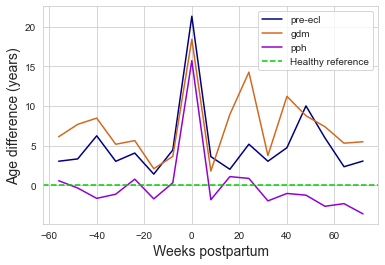

In [41]:
from preg_aging.clalit_parser import get_clalit_data

preg_data = pd.DataFrame({test_name: get_clalit_data(test_name, r"C:\Users\ronmo\PycharmProjects\PregAging\csvs\pregnancy.4w")["val_mean"] for test_name in tests})
preecl_data = pd.DataFrame({test_name: get_clalit_data(test_name, r"C:\Users\ronmo\PycharmProjects\PregAging\csvs\pregnancy.pre-eclampsia.4w")["val_mean"] for test_name in tests})
gdm_data = pd.DataFrame({test_name: get_clalit_data(test_name, r"C:\Users\ronmo\PycharmProjects\PregAging\csvs\pregnancy.gdm.4w")["val_mean"] for test_name in tests})
pph_data = pd.DataFrame({test_name: get_clalit_data(test_name, r"C:\Users\ronmo\PycharmProjects\PregAging\csvs\pregnancy.postpartum_hemorrhage.4w")["val_mean"] for test_name in tests})
# plt.plot(preg_data.index, model.predict(add_constant(preg_data)), label="healthy", color="#00cc00")
lower_res_fac_2_index = preg_data.index[:-1].to_numpy().reshape(-1,2).mean(axis=1)
predict_ecl_diff = (model.predict(add_constant(preecl_data.interpolate())) - model.predict(add_constant(preg_data))).to_numpy()
predict_gdm_diff = (model.predict(add_constant(gdm_data.interpolate())) - model.predict(add_constant(preg_data))).to_numpy()
predict_pph_diff = (model.predict(add_constant(pph_data.interpolate())) - model.predict(add_constant(preg_data))).to_numpy()
plt.plot(lower_res_fac_2_index, predict_ecl_diff[:-1].reshape(-1, 2).mean(axis=1), label="pre-ecl", c="navy")
plt.plot(lower_res_fac_2_index, predict_gdm_diff[:-1].reshape(-1, 2).mean(axis=1), label="gdm", c="chocolate")
plt.plot(lower_res_fac_2_index, predict_pph_diff[:-1].reshape(-1, 2).mean(axis=1), label="pph", color="darkviolet")
plt.axhline(0, label="Healthy reference", c="#00cc00", linestyle="--")
plt.legend()
plt.ylabel("Age difference (years)", fontsize=14)
plt.xlabel("Weeks postpartum", fontsize=14)
plt.show()

In [16]:
from preg_aging.analyses import sample_tests_mean_val, sample_regression_params
reps = sample_tests_mean_val(tests, 10000, r"C:\Users\ronmo\PycharmProjects\PregAging\csvs\pregnancy.gdm.4w")
params = sample_regression_params(comp_model.cov_params(), comp_model.params, reps.shape[0])
#preg_data = sample_tests_mean_val(tests, 10000, r"C:\Users\ronmo\PycharmProjects\PregAging\csvs\pregnancy.4w")

In [39]:
# pred = pd.DataFrame(data=np.einsum('ij,ij->i', add_constant(reps) - add_constant(preg_data) , params), columns=["age"], index=reps.index)
# #pred.loc[2] = 0
# import plotly.express as px
# display(px.violin(pred.reset_index(), x="week", y="age"))
# pred = pd.DataFrame(model.predict(add_constant(reps) - add_constant(preg_data)).to_numpy(), columns=["age"], index=reps.index)
# #pred.loc[2] = 0
# display(px.violin(pred.reset_index(), x="week", y="age"))

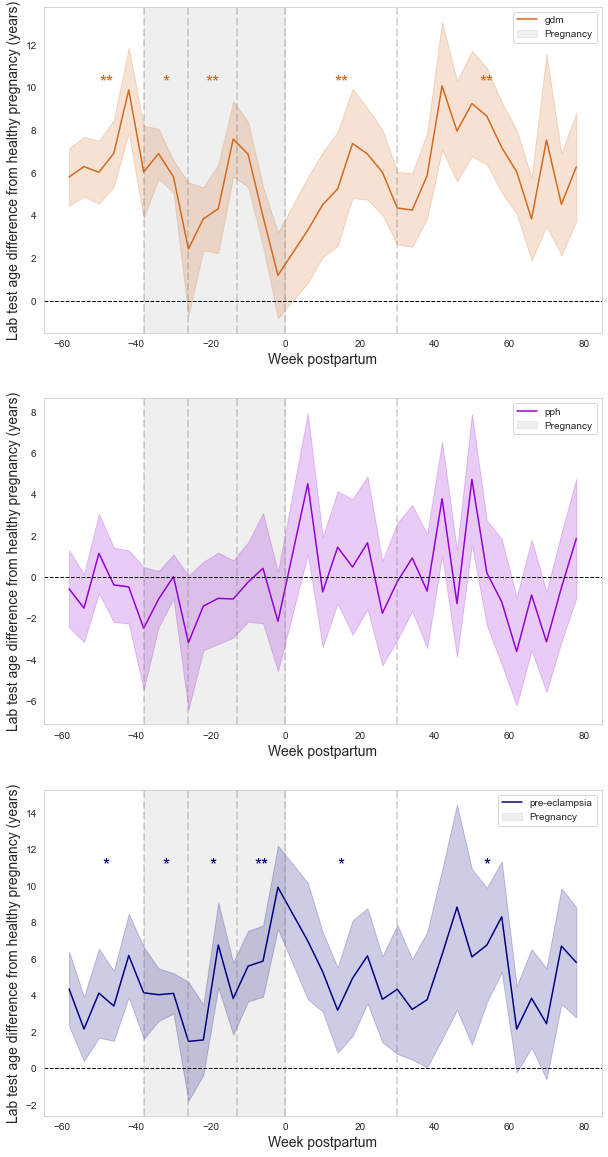

In [20]:
from preg_aging.plotting import plot_age_acceleration_by_lin_reg
fig = plot_age_acceleration_by_lin_reg(comp_model, r"C:\Users\ronmo\PycharmProjects\PregAging\csvs\pregnancy.4w", [r"C:\Users\ronmo\PycharmProjects\PregAging\csvs\pregnancy.pre-eclampsia.4w",r"C:\Users\ronmo\PycharmProjects\PregAging\csvs\pregnancy.gdm.4w",                                      r"C:\Users\ronmo\PycharmProjects\PregAging\csvs\pregnancy.postpartum_hemorrhage.4w"],
                                 exclude_points=[2], compared_color_map={r"pre-eclampsia": "navy",
                                                                         "gdm": "chocolate",
                                                                         "pph": "darkviolet"},
                                       p_val_bins=[-58, -38, -26, -13, 0, 30, 78], use_fill=True)

# fig.savefig(os.path.join("graphs", "age_acceleration.pdf"))


In [44]:
type(comp_model)

statsmodels.base.elastic_net.RegularizedResultsWrapper

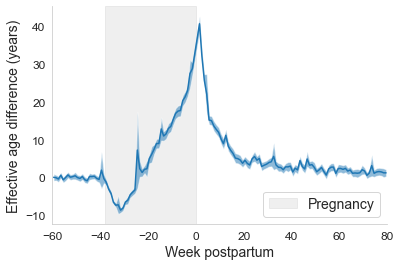

In [20]:
from preg_aging.plotting import plot_model_prediction
f, _, pred = plot_model_prediction(model, use_fill=True, exclude_points=[-0.5, 0.5])
#f.savefig(os.path.join("graphs", "pregnancy_pred.svg"))

In [17]:
pred

,age,sd
week,,
-59.5,0.080322,0.431787
-58.5,-0.024323,0.377406
-57.5,-0.381751,0.413787
-56.5,0.602599,0.376885
-55.5,-0.600573,0.371331
...,...,...
75.5,1.476243,0.500347
76.5,1.548735,0.490193
77.5,1.539044,0.530129


(<Figure size 1080x1080 with 9 Axes>,
 array([[<Axes: xlabel='Labnorm quantile diff (age, [20, 80])', ylabel='Pregnancy max quantile diff (week, [-40, 0])'>,
         <Axes: xlabel='Labnorm quantile diff (age, [20, 80])', ylabel='Pregnancy max quantile diff (week, [-40, 0])'>,
         <Axes: xlabel='Labnorm quantile diff (age, [20, 80])', ylabel='Pregnancy max quantile diff (week, [-40, 0])'>],
        [<Axes: xlabel='Labnorm quantile diff (age, [20, 80])', ylabel='Pregnancy max quantile diff (week, [-40, 0])'>,
         <Axes: xlabel='Labnorm quantile diff (age, [20, 80])', ylabel='Pregnancy max quantile diff (week, [-40, 0])'>,
         <Axes: xlabel='Labnorm quantile diff (age, [20, 80])', ylabel='Pregnancy max quantile diff (week, [-40, 0])'>],
        [<Axes: xlabel='Labnorm quantile diff (age, [20, 80])', ylabel='Pregnancy max quantile diff (week, [-40, 0])'>,
         <Axes: xlabel='Labnorm quantile diff (age, [20, 80])', ylabel='Pregnancy max quantile diff (week, [-40, 0])'>,


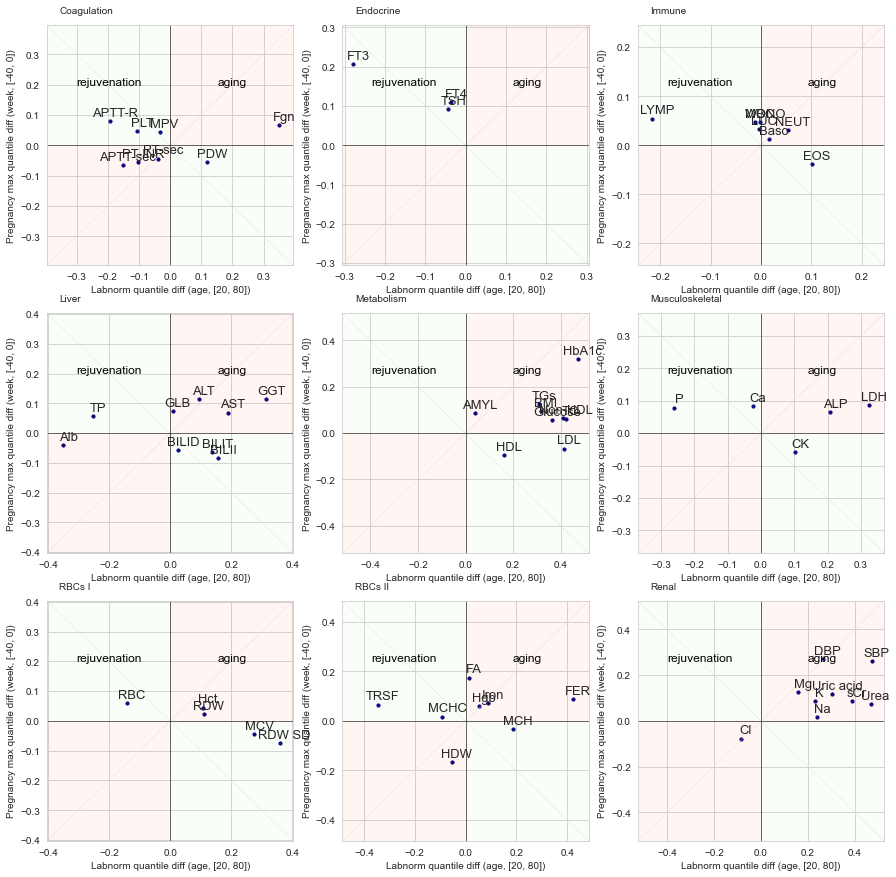

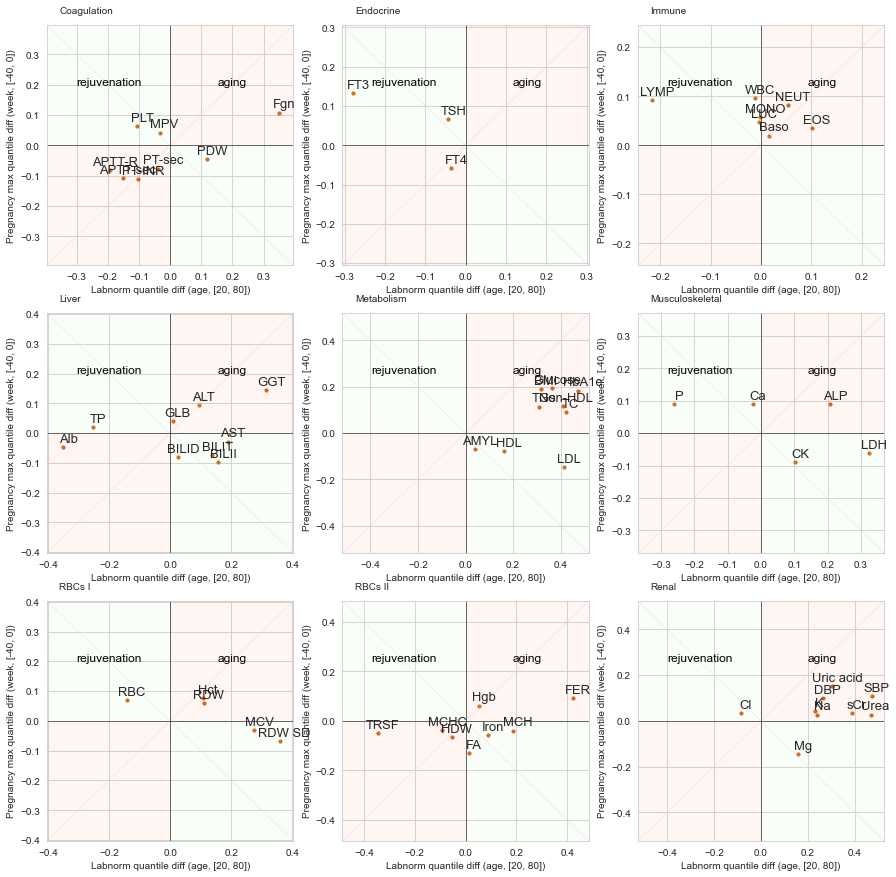

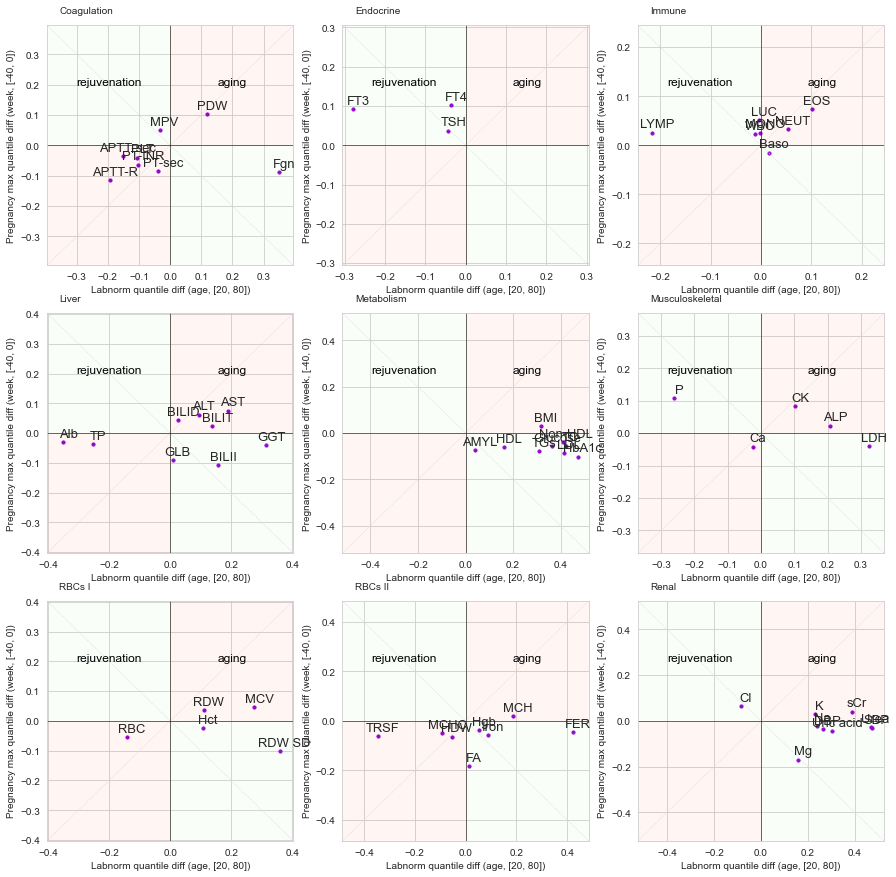

In [36]:
from preg_aging.plotting import plot_diff_grid_pathologies

plot_diff_grid_pathologies(test_groups, r"C:\Users\ronmo\PycharmProjects\PregAging\csvs\pregnancy.pre-eclampsia.4w",
                           r"C:\Users\ronmo\PycharmProjects\PregAging\csvs\pregnancy.4w", color="navy")
plot_diff_grid_pathologies(test_groups, r"C:\Users\ronmo\PycharmProjects\PregAging\csvs\pregnancy.gdm.4w",
                           r"C:\Users\ronmo\PycharmProjects\PregAging\csvs\pregnancy.4w", color="chocolate")
plot_diff_grid_pathologies(test_groups, r"C:\Users\ronmo\PycharmProjects\PregAging\csvs\pregnancy.postpartum_hemorrhage.4w",
                           r"C:\Users\ronmo\PycharmProjects\PregAging\csvs\pregnancy.4w", color="darkviolet")

## Regression weight visualization

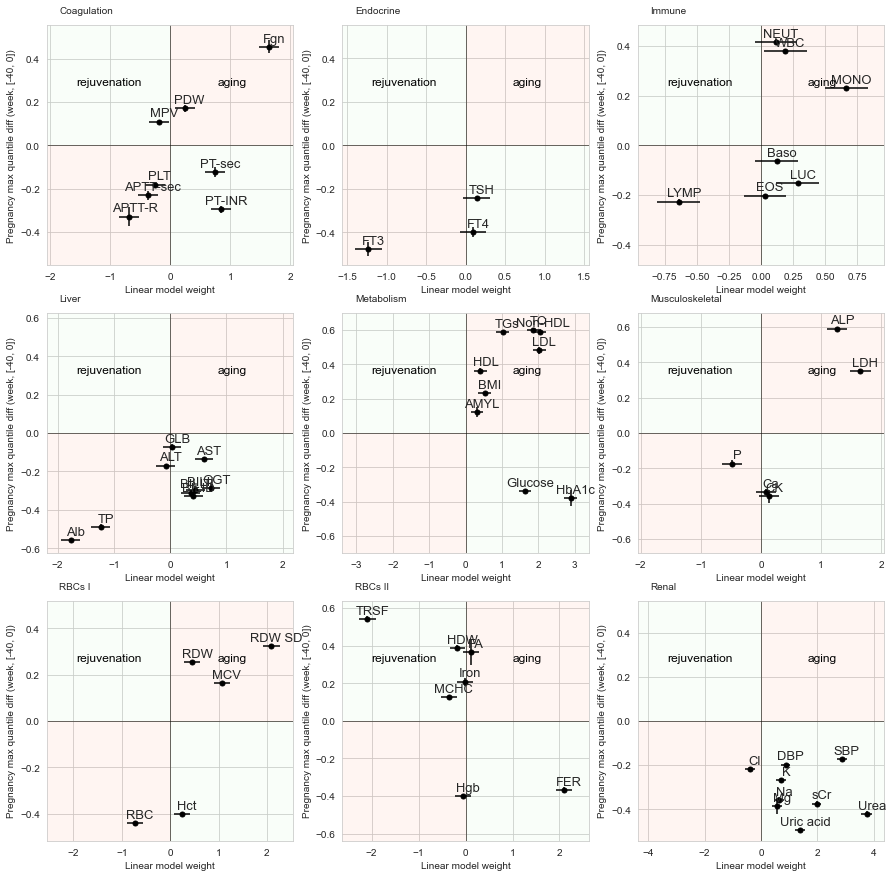

In [99]:
from preg_aging.plotting import plot_diff_grid_model
names_to_weights = norm_model.conf_int().iloc[1:].rename(columns={0:"bottom_ci", 1:"top_ci"})  # skip intercept
names_to_weights["value"] = norm_model.params.iloc[1:]  # skip intercept
_ = plot_diff_grid_model(test_groups, names_to_weights)

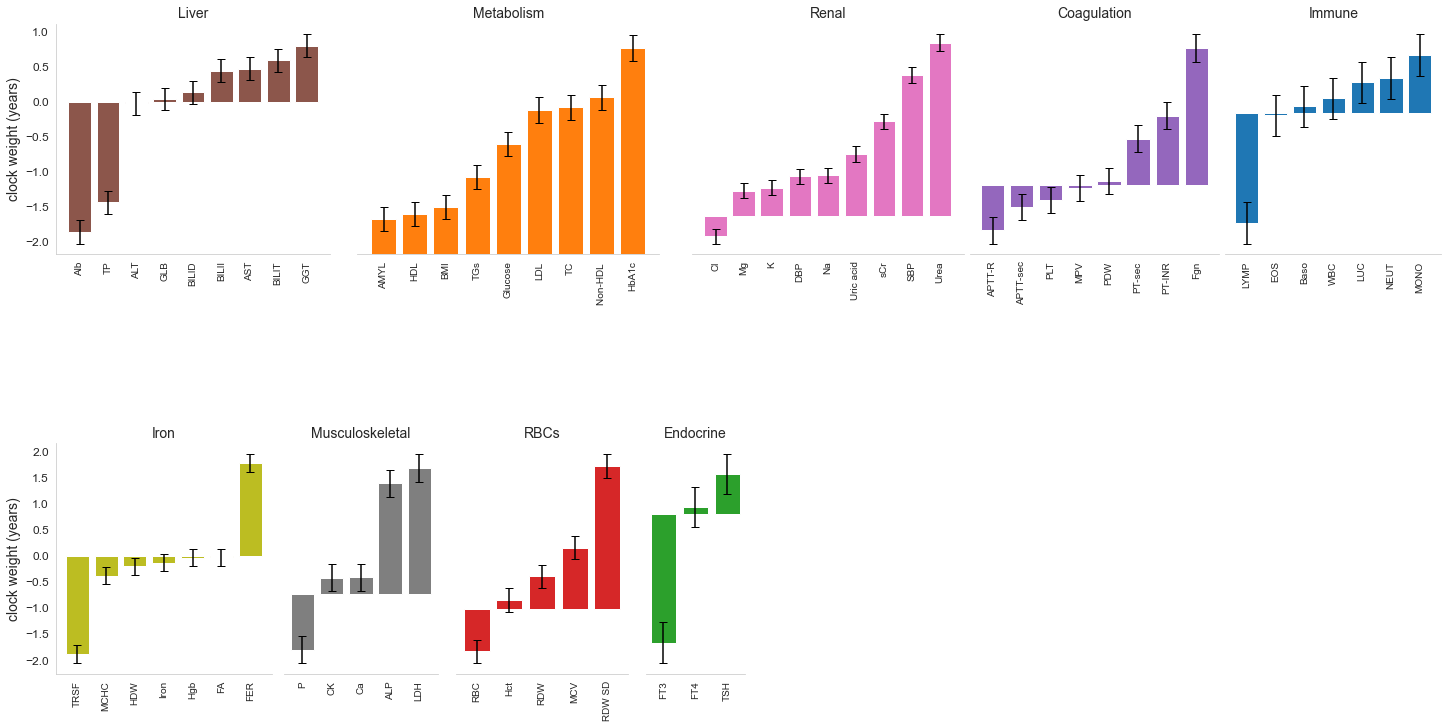

In [18]:
from preg_aging.plotting import plot_model_weights
color_map = {'Immune': '#1f77b4', "Metabolism": '#ff7f0e', "Endocrine": '#2ca02c', "RBCs": '#d62728', "Coagulation": '#9467bd', "Liver": '#8c564b', "Renal": '#e377c2', "Musculoskeletal": '#7f7f7f', "Iron": '#bcbd22'}
f = plot_model_weights(test_groups, norm_model, color_map)
f.savefig(os.path.join("graphs", "model_weights.svg"))

(<Figure size 1080x1080 with 9 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >]], dtype=object))

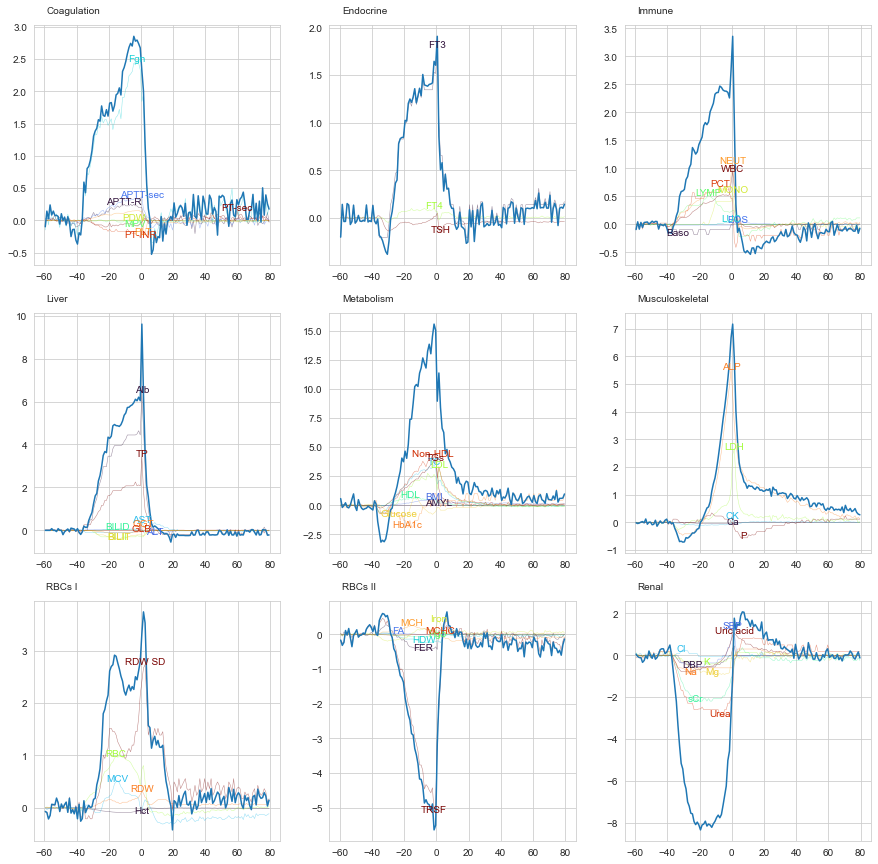

In [6]:
from preg_aging.plotting import plot_groups_linear_prediction
test_groups_rbc_comp = test_groups.copy()
test_groups_rbc_comp["RBCs"] = test_groups["RBCs I"].append(test_groups["RBCs II"])
test_groups_rbc_comp.pop("RBCs I")
test_groups_rbc_comp.pop("RBCs II")
plot_groups_linear_prediction(test_groups, model.params)

In [28]:
included_tests = stats[~((stats["pearson-p"] > 0.05) | (stats["spearman"].abs() < 0.6))].index

<Axes: >

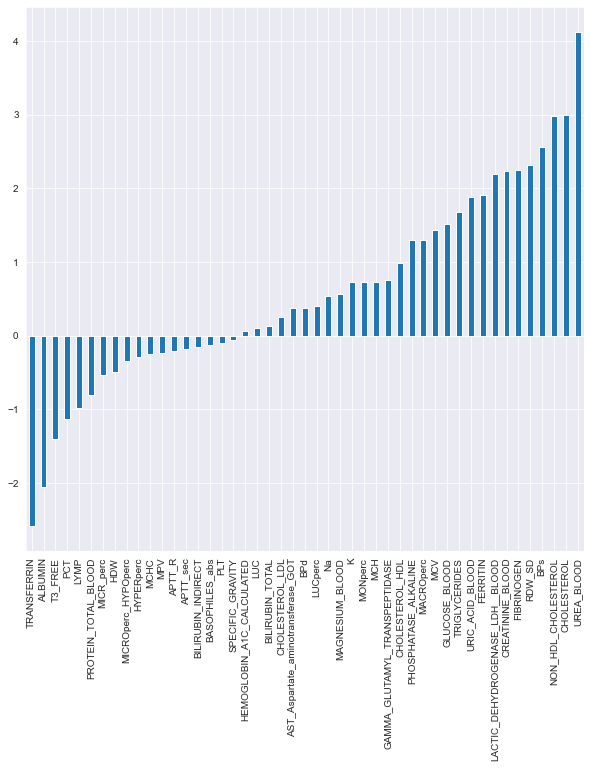

In [65]:
norm_model.params[norm_model.params.index.isin(included_tests)].sort_values().plot(kind="bar", figsize=(10,10))


## Botched GAM attempt

In [51]:
from pygam import LinearGAM, s
from functools import reduce

included_tests_indices = regression.columns.get_indexer(included_tests)
splines = reduce(lambda x,y: x + y, [s(i, n_splines=10) for i in range(len(included_tests))])
gam = LinearGAM(splines).gridsearch(regression[included_tests].to_numpy(), age.to_numpy())


100% (11 of 11) |########################| Elapsed Time: 0:00:06 Time:  0:00:060:00


In [21]:
from preg_aging.plotting import plot_labnorm_mean_std
from tqdm import tqdm
from preg_aging.clalit_parser import get_clalit_data

preg_data = pd.DataFrame({test_name: get_clalit_data(test_name)["val_50"] for test_name in tests})[included_tests]
fig, axs = plt.subplots(nrows=len(gam.terms), ncols=2, figsize=(5.2 * 2, len(gam.terms) * 5))
for i, term in enumerate(tqdm(gam.terms)):
    if term.isintercept:
        continue
    test_name = included_tests[term.feature]
    pre_conception = preg_data[test_name].loc[-60:-38]
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX + (XX - XX.mean()) * 1.2, width=0.95)
    axs[i, 0].plot(XX[:, term.feature], pdep)
    #axs[i, 0].plot(XX[:, term.feature], confi, c='r', ls='--')
    axs[i, 0].set_title(test_name)
    #axs[i, 0].hlines(gam.partial_dependence(term=i, X=(np.array([pre_conception.min()]),), meshgrid=True)[0], 0, xmax=pre_conception.min(), colors=["r"], linestyles="--")
    plot_labnorm_mean_std(axs[i, 1], test_name)
fig.show()

NameError: name 'included_tests' is not defined

In [25]:
import plotly.express as px
alb_age = pd.concat([regression["ALBUMIN"], age], axis=1)
display(alb_age.sort_values("ALBUMIN"))
px.scatter(pd.concat([regression, age], axis=1), x="BMI", y="age")

,ALBUMIN,age
3913,1.90329,85.00000
4025,1.98609,87.00000
3873,2.00000,84.00000
4022,2.03552,87.00000
4102,2.10475,88.00000
...,...,...
148,5.06256,22.00000
72,5.07210,21.00000
77,5.09000,21.00000
68,5.09000,21.00000


In [136]:
next(iter(age.to_frame().groupby(age.name).indices))

np.float64(20.0)

<ipython-input-35-034891d37429>:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



<Axes: xlabel='age'>

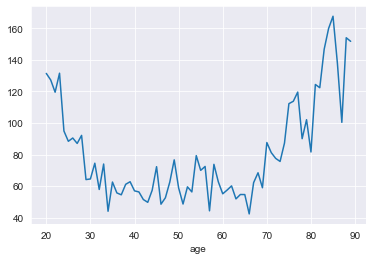

In [35]:
from sklearn.metrics import mean_squared_error
pd.concat([regression, age], axis=1).groupby(age.name).apply(lambda df: mean_squared_error(df[age.name], gam.predict(df.drop(columns=[age.name])))).plot()
# for one_age, row_indices in age.to_frame().groupby(age.name).indices.items():
#     print(((gam.predict(regression.iloc[row_indices]) - one_age) ** 2).mean())

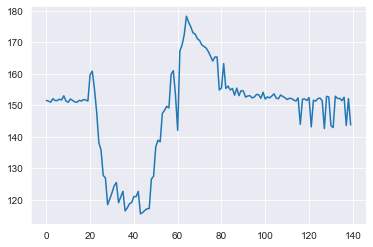

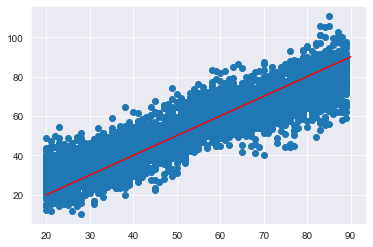

In [75]:
plt.plot(gam.predict(preg_data))
plt.show()
plt.scatter(age, gam.predict(regression[included_tests]))
plt.plot([20,90],[20,90], c="r")